In [1]:
import re, io
import os, json
import pandas as pd
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
from data_ingestor import *
from time_series import *

plt.style.use('seaborn')
%matplotlib inline

from variables import init_variables
path_to_json, column_dict, inconsistent_col, keys = init_variables()

Importing plotly failed. Interactive plots will not work.


In [2]:
master_df = read_all_json_files(path_to_json, column_dict, inconsistent_col, keys)
master_df_clean = maintain_datatype(master_df)
master_df_clean = drop_non_numeric_invoice(master_df_clean)

In [3]:
df_EIRE = master_df_clean[master_df_clean['country']=='EIRE']

In [4]:
df_day_EIRE = df_EIRE.groupby(['year', 'month', 'day']).agg({'times_viewed':'sum', 'price':'sum',
                                        'country':'first',}).reset_index()
df_day_EIRE = create_date_col(df_day_EIRE)
df_day_EIRE = df_day_EIRE[df_day_EIRE['price']<=20000]
df_day_EIRE.head()

,year,month,day,times_viewed,price,country,Date
0,2017,11,28,545,375.99,EIRE,2017-11-28
1,2017,11,30,192,194.22,EIRE,2017-11-30
2,2017,12,4,398,470.65,EIRE,2017-12-04
3,2017,12,5,234,62.00,EIRE,2017-12-05
4,2017,12,7,104,133.31,EIRE,2017-12-07


In [5]:
ts_EIRE = df_day_EIRE[['price', 'Date']].set_index('Date') # Set Date as index
ts_EIRE = ts_EIRE['price']

In [6]:
ts_log_EIRE = np.log(ts_EIRE)
ts_log_diff_EIRE = ts_log_EIRE - ts_log_EIRE.shift()
ts_log_diff_EIRE.dropna(inplace=True)

/Users/aishwarya.das1ibm.com/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/aishwarya.das1ibm.com/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5, 1.0, 'RSS: nan')

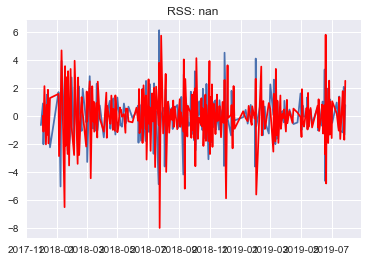

In [7]:
model_EIRE = ARIMA(ts_log_diff_EIRE, order=(1, 1, 0))  
results_AR_EIRE = model_EIRE.fit(disp=-1)  
plt.plot(ts_log_diff_EIRE)
plt.plot(results_AR_EIRE.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR_EIRE.fittedvalues-ts_log_diff_EIRE)**2))

/Users/aishwarya.das1ibm.com/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/aishwarya.das1ibm.com/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5, 1.0, 'RSS: 273.5017')

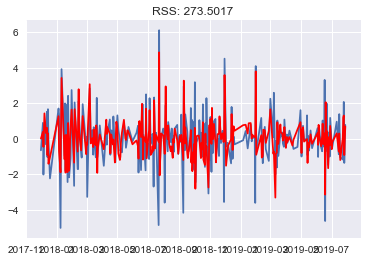

In [8]:
model_EIRE = ARIMA(ts_log_EIRE, order=(2, 1, 1))  
results_ARIMA_EIRE = model_EIRE.fit(disp=-1)  
plt.plot(ts_log_diff_EIRE)
plt.plot(results_ARIMA_EIRE.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA_EIRE.fittedvalues-ts_log_diff_EIRE)**2))

Text(0.5, 1.0, 'RMSE: 990.7235')

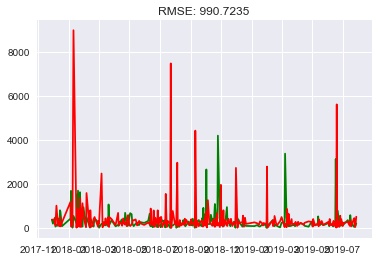

In [9]:
predictions_ARIMA_diff_EIRE = pd.Series(results_AR_EIRE.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum_EIRE = predictions_ARIMA_diff_EIRE.cumsum()
predictions_ARIMA_log_EIRE = pd.Series(ts_log_EIRE.iloc[0], index=ts_log_EIRE.index)
predictions_ARIMA_log_EIRE = predictions_ARIMA_log_EIRE.add(predictions_ARIMA_diff_cumsum_EIRE,fill_value=0)
predictions_ARIMA_EIRE = np.exp(predictions_ARIMA_log_EIRE)
plt.plot(ts_EIRE, color='green')
plt.plot(predictions_ARIMA_EIRE, color='red')
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA_EIRE-ts_EIRE)**2)/len(ts_EIRE)))

In [10]:
predictions_ARIMA_EIRE.tail()

Date
2019-07-23    405.404941
2019-07-24    445.709061
2019-07-25    230.362161
2019-07-26     41.969241
2019-07-28    510.909397
dtype: float64

In [11]:
ts_EIRE.head()

Date
2017-11-28    375.99
2017-11-30    194.22
2017-12-04    470.65
2017-12-05     62.00
2017-12-07    133.31
Name: price, dtype: float64

##### Prophet 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-11-28,282.0,-178.0,706.0,282.0,282.0,-15.0,-15.0,-15.0,-15.0,-15.0,-15.0,0.0,0.0,0.0,267.0
1,2017-11-29,285.0,-165.0,730.0,285.0,285.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,0.0,0.0,0.0,273.0
2,2017-11-30,288.0,-149.0,727.0,288.0,288.0,-7.0,-7.0,-7.0,-7.0,-7.0,-7.0,0.0,0.0,0.0,282.0
3,2017-12-01,292.0,-97.0,759.0,292.0,292.0,63.0,63.0,63.0,63.0,63.0,63.0,0.0,0.0,0.0,355.0
4,2017-12-02,295.0,-133.0,752.0,295.0,295.0,15.0,15.0,15.0,15.0,15.0,15.0,0.0,0.0,0.0,310.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,2019-11-01,222.0,-232.0,828.0,-54.0,503.0,63.0,63.0,63.0,63.0,63.0,63.0,0.0,0.0,0.0,285.0
704,2019-11-02,222.0,-326.0,780.0,-61.0,507.0,15.0,15.0,15.0,15.0,15.0,15.0,0.0,0.0,0.0,236.0
705,2019-11-03,222.0,-363.0,719.0,-67.0,511.0,-34.0,-34.0,-34.0,-34.0,-34.0,-34.0,0.0,0.0,0.0,188.0
706,2019-11-04,221.0,-351.0,745.0,-71.0,516.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,0.0,0.0,0.0,212.0


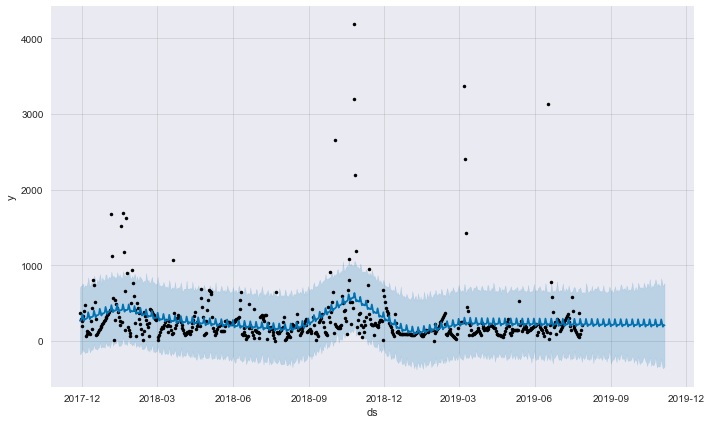

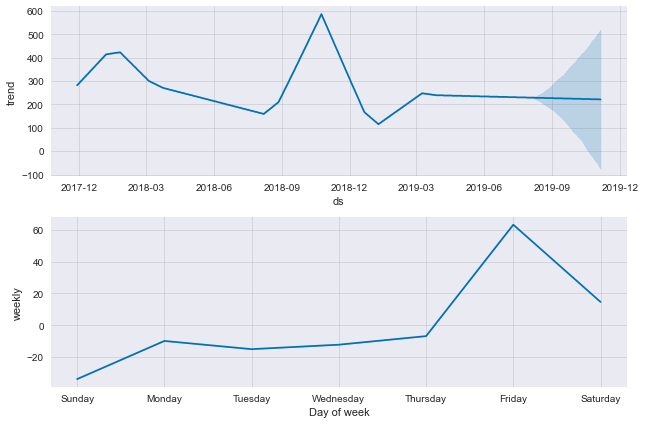

In [12]:
prophet_forecast(df_day_EIRE, 100)